In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.multiplex_utils import multiplex_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20201206_transfer_decidua"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [4]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200603_Decidua_with_old_256x256"

test_size=0.2
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']
print(X_train.shape, X_val.shape)

(1280, 256, 256, 6) (320, 256, 256, 6)


X.shape: (1280, 256, 256, 6)
y.shape: (1280, 256, 256, 1)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]


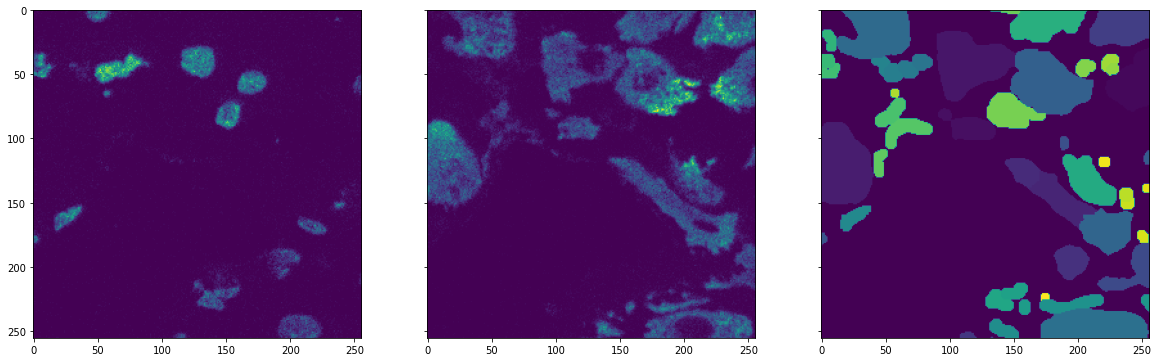

In [5]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_val.shape[0]):
        y_val[i], _, _ = relabel_sequential(y_val[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)

idx = 303
axes[0].imshow(X_train[idx,:,:,0])
axes[1].imshow(X_train[idx,:,:,1])
axes[2].imshow(y_train[idx,:,:,0])
print(np.unique(y_train[idx]))

In [6]:
X_train = multiplex_preprocess(X_train)
X_val = multiplex_preprocess(X_val)

In [27]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 6),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True,
    use_imagenet=True)

In [28]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed_4_heads'

n_epoch = 40  # Number of training epochs

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 8

min_objects = 3  # throw out images with fewer than this many objects
seed=0
model_name

'20200603_Decidua_with_old_256x256_deep_watershed_4_heads'

In [29]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance', 'outer-distance', 'fgbg', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'},
                      'outer-distance': {'erosion_width': 1}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'outer-distance', 'fgbg', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'},
                      'outer-distance': {'erosion_width': 1}},
    min_objects=min_objects,
    batch_size=batch_size)

W1216 16:09:25.137424 140517057316672 semantic.py:159] Removing 6 of 1280 images with fewer than 3 objects.
W1216 16:09:43.356722 140517057316672 semantic.py:159] Removing 1 of 320 images with fewer than 3 objects.


IndexError: index 1 is out of bounds for axis 3 with size 1

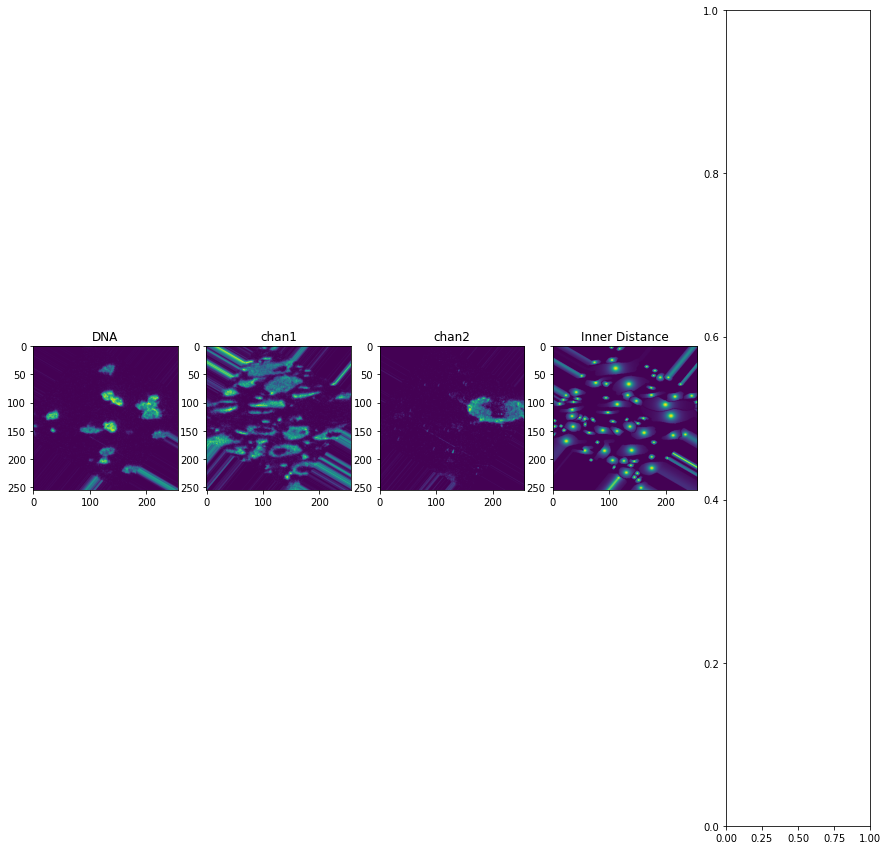

In [30]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
pixelwise = outputs[1]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('DNA')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('chan1')

axes[2].imshow(img[:, :, 2])
axes[2].set_title('chan2')

axes[3].imshow(inner_distance[0, ..., 0])
axes[3].set_title('Inner Distance')

axes[4].imshow(pixelwise[0, ..., 1])
axes[4].set_title('Pixelwise interior')

plt.show()

In [31]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [32]:
new_model.compile(loss=loss, optimizer=optimizer)

In [33]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    #steps_per_epoch=300,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/40
158/159 [============================>.] - ETA: 0s - loss: 0.1591 - semantic_0_loss: 0.0439 - semantic_1_loss: 0.0971 - semantic_2_loss: 0.0063 - semantic_3_loss: 0.0118
Epoch 00001: val_loss improved from inf to 0.20323, saving model to /data/analyses/20201206_transfer_decidua/20200603_Decidua_with_old_256x256_deep_watershed_4_heads.h5
159/159 [==============================] - 213s 1s/step - loss: 0.1591 - semantic_0_loss: 0.0439 - semantic_1_loss: 0.0972 - semantic_2_loss: 0.0063 - semantic_3_loss: 0.0118 - val_loss: 0.2032 - val_semantic_0_loss: 0.0442 - val_semantic_1_loss: 0.0994 - val_semantic_2_loss: 0.0325 - val_semantic_3_loss: 0.0271
Epoch 2/40
158/159 [============================>.] - ETA: 0s - loss: 0.0984 - semantic_0_loss: 0.0292 - semantic_1_loss: 0.0556 - semantic_2_loss: 0.0045 - semantic_3_loss: 0.0090
Epoch 00002: val_loss did not improve from 0.20323
159/159 [==============================] - 72s 456ms/step - loss: 0.0982 - semantic_

Epoch 14/40
158/159 [============================>.] - ETA: 0s - loss: 0.0548 - semantic_0_loss: 0.0163 - semantic_1_loss: 0.0293 - semantic_2_loss: 0.0028 - semantic_3_loss: 0.0064
Epoch 00014: val_loss improved from 0.05144 to 0.05086, saving model to /data/analyses/20201206_transfer_decidua/20200603_Decidua_with_old_256x256_deep_watershed_4_heads.h5
159/159 [==============================] - 71s 447ms/step - loss: 0.0547 - semantic_0_loss: 0.0163 - semantic_1_loss: 0.0293 - semantic_2_loss: 0.0028 - semantic_3_loss: 0.0064 - val_loss: 0.0509 - val_semantic_0_loss: 0.0174 - val_semantic_1_loss: 0.0245 - val_semantic_2_loss: 0.0027 - val_semantic_3_loss: 0.0062
Epoch 15/40
158/159 [============================>.] - ETA: 0s - loss: 0.0550 - semantic_0_loss: 0.0162 - semantic_1_loss: 0.0296 - semantic_2_loss: 0.0028 - semantic_3_loss: 0.0064
Epoch 00015: val_loss improved from 0.05086 to 0.05015, saving model to /data/analyses/20201206_transfer_decidua/20200603_Decidua_with_old_256x256_

158/159 [============================>.] - ETA: 0s - loss: 0.0512 - semantic_0_loss: 0.0151 - semantic_1_loss: 0.0274 - semantic_2_loss: 0.0026 - semantic_3_loss: 0.0060
Epoch 00026: val_loss improved from 0.04672 to 0.04657, saving model to /data/analyses/20201206_transfer_decidua/20200603_Decidua_with_old_256x256_deep_watershed_4_heads.h5
159/159 [==============================] - 73s 457ms/step - loss: 0.0512 - semantic_0_loss: 0.0151 - semantic_1_loss: 0.0274 - semantic_2_loss: 0.0026 - semantic_3_loss: 0.0060 - val_loss: 0.0466 - val_semantic_0_loss: 0.0159 - val_semantic_1_loss: 0.0223 - val_semantic_2_loss: 0.0025 - val_semantic_3_loss: 0.0059
Epoch 27/40
158/159 [============================>.] - ETA: 0s - loss: 0.0506 - semantic_0_loss: 0.0150 - semantic_1_loss: 0.0270 - semantic_2_loss: 0.0026 - semantic_3_loss: 0.0060
Epoch 00027: val_loss improved from 0.04657 to 0.04641, saving model to /data/analyses/20201206_transfer_decidua/20200603_Decidua_with_old_256x256_deep_watersh

158/159 [============================>.] - ETA: 0s - loss: 0.0489 - semantic_0_loss: 0.0144 - semantic_1_loss: 0.0261 - semantic_2_loss: 0.0025 - semantic_3_loss: 0.0059
Epoch 00038: val_loss improved from 0.04472 to 0.04466, saving model to /data/analyses/20201206_transfer_decidua/20200603_Decidua_with_old_256x256_deep_watershed_4_heads.h5
159/159 [==============================] - 71s 444ms/step - loss: 0.0489 - semantic_0_loss: 0.0144 - semantic_1_loss: 0.0261 - semantic_2_loss: 0.0025 - semantic_3_loss: 0.0059 - val_loss: 0.0447 - val_semantic_0_loss: 0.0152 - val_semantic_1_loss: 0.0213 - val_semantic_2_loss: 0.0025 - val_semantic_3_loss: 0.0057
Epoch 39/40
158/159 [============================>.] - ETA: 0s - loss: 0.0492 - semantic_0_loss: 0.0145 - semantic_1_loss: 0.0263 - semantic_2_loss: 0.0025 - semantic_3_loss: 0.0059
Epoch 00039: val_loss improved from 0.04466 to 0.04456, saving model to /data/analyses/20201206_transfer_decidua/20200603_Decidua_with_old_256x256_deep_watersh

In [6]:
new_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [24]:
new_model.load_weights(os.path.join('/data/models/20200602_Decidua_New_Data/20200603_Decidua_with_old_256x256_deep_watershed_all_params.h5'))

In [16]:
import xarray as xr
data_dir = '/data/shirley/cohort/'
input_data = xr.open_dataarray(data_dir + 'deepcell_input.xr')

In [10]:
x = input_data.loc[['18_31785_5_15'], ...].values

In [11]:
x.shape

(2048, 2048, 6)

In [34]:
preprocessed = multiplex_preprocess(input_data.loc[['18_31785_5_15'], ...].values)

In [35]:
from deepcell.applications import MultiplexSegmentation
from deepcell_toolbox.utils import tile_image, untile_image
app = MultiplexSegmentation(use_pretrained_weights=False)
tiled_data, tile_info = tile_image(preprocessed, model_input_shape=(256, 256))
model_output = new_model.predict(tiled_data)
inner_distance, outer_distance, fgbg, pixelwise = app._untile_output(model_output, tile_info)

In [36]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
labeled_images = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[..., 1:2]},
                                  maxima_threshold=0.05, maxima_model_smooth=0,
                                  interior_threshold=0.25,
                                  interior_model_smooth=2,
                                  radius=3,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10,)

In [17]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries[..., 0] > 0, :] = 1
    
    return overlay_data

In [18]:
RGB_data = make_color_overlay(preprocessed[..., :2])
predicted_overlay = make_outline_overlay(RGB_data, labeled_images)

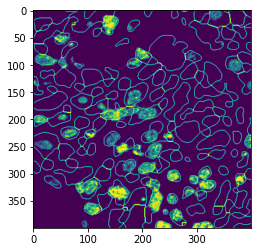

In [21]:
import matplotlib.pyplot as plt
plt.imshow(predicted_overlay[0, 400:800, :400, 0])

In [37]:
import skimage.io as io
io.imsave(MODEL_DIR + '/test_segmentation_4_heads.tiff', labeled_images[0, :, :, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: /data/analyses/20201206_transfer_decidua/test_segmentation_4_heads.tiff is a low contrast image
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  


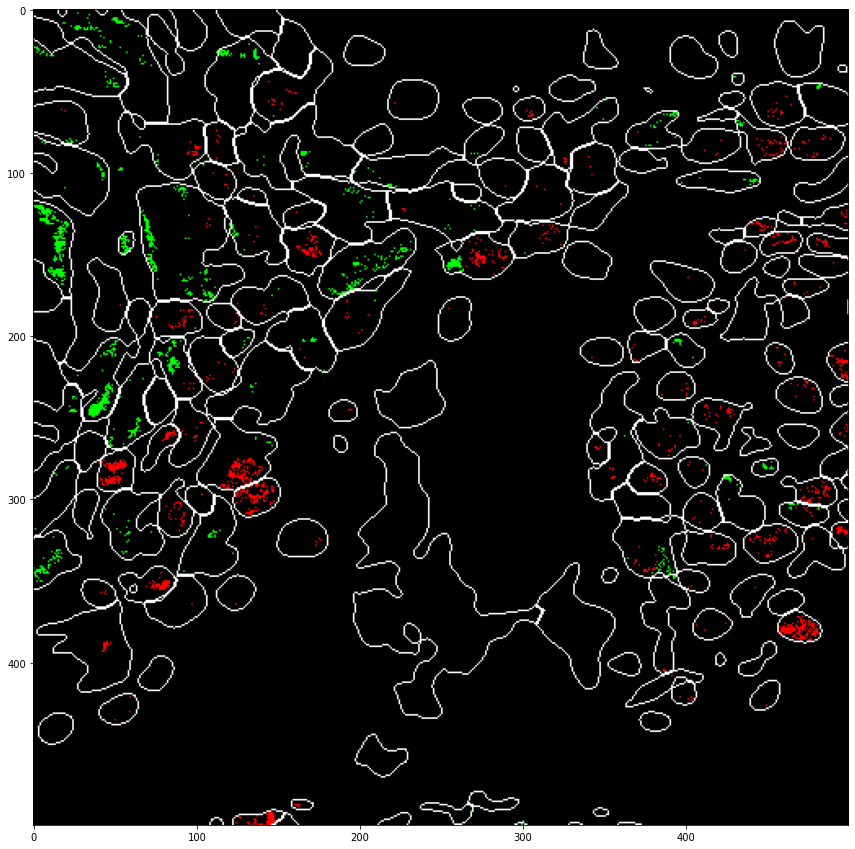

In [62]:
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 1
#fig, axes = plt.subplots(2,3,figsize=(30,20))
fig, axes = plt.subplots(figsize=(15, 15))
axes.imshow(predicted_overlay[index, :500, :500, :])
# axes = axes.flatten()
# axes[0].imshow(RGB_data[index[0],...])
# axes[1].imshow(inner_distance[index[0],...,0], cmap='jet')
# axes[2].imshow(pixelwise[index[0],...,0], cmap='jet')
# axes[3].imshow(predicted_overlay[index[0], ...], cmap=cmap)
# # axes[4].imshow(true_overlay[index[0], ...], cmap=cmap)

# axes[0].set_title('Color_overlay', fontsize=24)
# axes[1].set_title('Inner distance', fontsize=24)
# axes[2].set_title('Pixelwise Border', fontsize=24)
# axes[3].set_title('Predicted Overlay', fontsize=24)
# # axes[4].set_title('True Overlay', fontsize=24)
# # axes[5].set_title('Ground Truth Mask', fontsize=24)

# for ax in axes.flatten():
#     ax.set_axis_off()

IndexError: index 17 is out of bounds for axis 0 with size 17

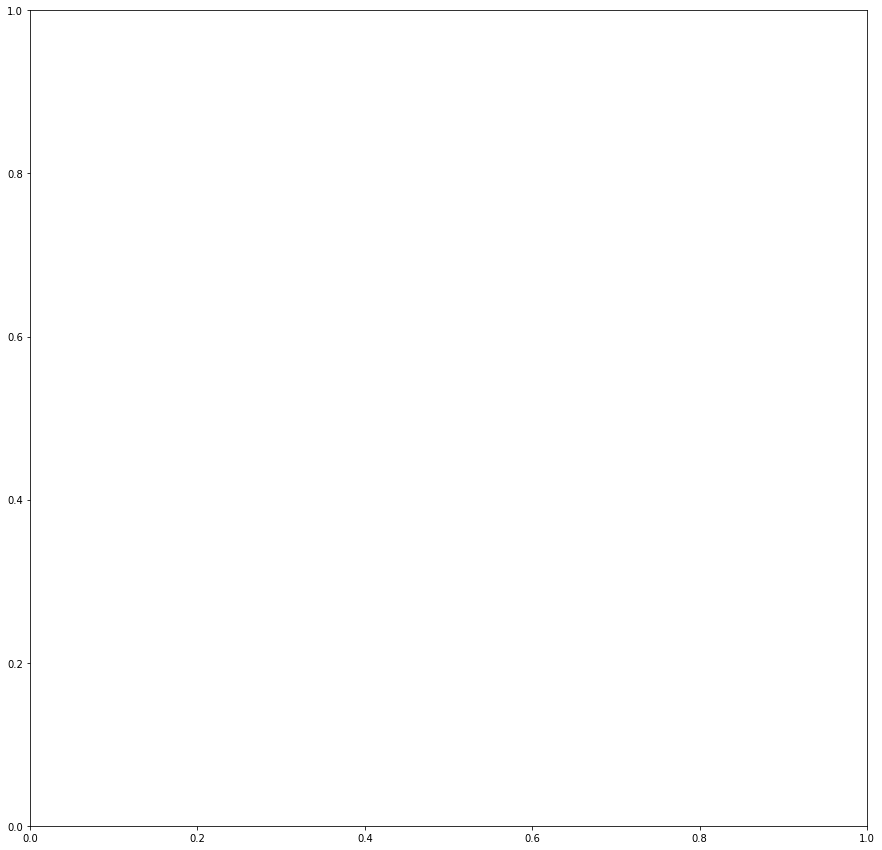

In [151]:
fig, axes = plt.subplots(figsize=(15,15))
axes.imshow(predicted_overlay[17, ...], cmap=cmap)
